# What is this project?

The project aims to address societal conflicts in less fortunate parts of the world by predicting and preparing for potential escalations. Evan Wheeler and UNICEF are utilizing statistical and data science methods to create three predictive models: 
 - a transformer-based deep learning language model (similar to ChatGPT)
 - a small feed-forward neural network (a simplified brain-inspired system)
 - xgboost gradient boosting machine learning model (the machine learning "gold standard")
 
Predicting regions most prone to conflict allows UNICEF to proactively ready resources, offering vital aid such as food and shelter, and aiding affected individuals in reconstructing their lives.
 
 
These models analyze social media, news reports, and similar data sources to forecast conflict escalation in unstable regions. If UNICEF would have the tools to succesfully predict which regions will have a breakout of conflict before it even happens, they would be more suited to critical ressources like food and shelter in advance.  
    
Each model employs different structures and approaches to leverage the available data for accurate predictions. As the models predictions vary in accuracy based on the type and variety of data available to them. The hypothesis is that these models preform better depending on the characteristics of the country they are predicting. (Think GPD, population, geography)

# What is the data?

We are given two datasets. One dataset contains the predicted probabilities from the three models of a near term conflict happening as well as real world data as to whether conflict occured that month.


The second dataset contains over 1300 different statistics for each country. The data consists mostly of two types of variables: continous variables - this is something like population or GDP; and classifications - world bank lending category, and "fragile states index" such as warning, alert, normal, etc. We will be calling these predictors.

It is our task to design a new *meta model* that can predict which predictive model will preform better for the different types of countries.

# What are the challenges of linear regression?

We will be using linear regression - a method that finds a straight line to understand and predict relationships between two things, like how the price of a house might change based on its size. Except our model will have many many straight lines, think of how you could have one line for predicting the price based on size, one based on number of bedrooms, ceiling height, etc.

Challenges:
- There are too many potenial predictors. When there are too many factors, the model can not decide which predictor to associate the change with. This is called co-linearity, meaning that two or more predictors could be responsible for the change in price.
- We want to maximize $R^2$ - a measure of how much is explained by our model, and how much variance is just random. A higher $R^2$ is better, and the more predictors the model can use, the more it details it can explain.
- Model building becomes a tug of war between choosing enough useful predictors to maximize predictive power and minimizing the number of predictors to be able to explain which ones are affecting the results.




In [1]:
#getting data
import pandas as pd
import numpy as np

df_indicators = pd.read_csv('country_indicators.csv')
df_preds = pd.read_csv('test_predictions.csv')
df = df_preds.merge(df_indicators, left_on='iso3', right_on='iso3', how='inner')

In [2]:
# Okay, so we first need to get the Probability Prediciton "Error"
df['error_transformer'] = np.abs(df.y_true_transformer-df.y_pred_proba_transformer)
df['error_ffnn'] = np.abs(df.y_true_ffnn-df.y_pred_proba_ffnn)
df['error_xgboost'] = np.abs(df.y_true_xgboost-df.y_pred_proba_xgboost)
df['total_error'] = df['error_transformer'] + df['error_ffnn'] + df['error_xgboost']

In [5]:
# But, then, what I wanted to do first was look at those "Progress Indicator" variables that kept
# getting mentioned; but, specifically, the actual indicator variable versions of these...
# This is code Evan Wheeler gave me and it does the trick to make the indicator variables I want

# make df of column names and their dtypes
df_cols = pd.DataFrame(df.dtypes, columns=('coldtype',)).reset_index().rename(columns={'index': 'colname'})
df_cols['coldtype'] = df_cols['coldtype'].astype('string')
# adjusting a potentially useful variable that might be considered label
df['fsi_rank'] = df['fsi_rank'].astype('string').str.replace(r'\D', '', regex=True).replace('', pd.NA)
# get list of numeric variables
num_vars = df_cols.query("coldtype=='float64'")['colname'].values
# these could be useful; but, I'm ignoring them for now to keep the demonstration simpler...

import itertools

# Indicator variables are often called "one hot" encodings
def one_hot(df, cols):
    """ One-hot encode given `cols` and add as new columns
        to `df`

        Returns tuple of `df` with new columns and list of
        new column names.
    """
    new_cols = list()
    new_col_names = list()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each)
        new_cols.append(dummies)
        new_col_names.append(dummies.columns.values)

    df = pd.concat([df]+new_cols, axis=1)
    new_col_names = list(itertools.chain.from_iterable(new_col_names))
    return df, new_col_names

# categorical variables we will turn into indicator ("one hot") variables
cat_vars = ['fsi_category', 'hdr_hdicode', 'hdr_region',
            'wbi_income_group', 'wbi_lending_category',
            'wbi_other_(emu_or_hipc)']
# Prof. Schwartz'z Note:
# I'm not sure if there are other categorical variables in this data that could also be transformed
# These are just the ones Evan initially used as examples as he described the objectives of the project

# get one hot encodings
df_oh, oh_cols = one_hot(df, cat_vars)
df_oh = df_oh.drop(columns=cat_vars)

#df_oh[['error_transformer','error_ffnn','error_xgboost'] + oh_cols]

### There are some columns that are unnecesary for the type of analysis we would like to do and will interfere with our results so we exclude them:

```'yearmonth', 'fips', 'y_pred_transformer', 'y_pred_proba_transformer', 'y_true_transformer', 'y_pred_xgboost', 'y_pred_proba_xgboost', 'y_true_xgboost', 'y_pred_ffnn', 'y_pred_proba_ffnn', 'y_true_ffnn', 'iso3', 'Unnamed: 0', 'error_transformer', 'error_ffnn', 'error_xgboost', 'total_error', 'fsi_year', 'fsi_rank'```



In [6]:
reduced_oh_cols = list(df_oh.columns[df_oh.isnull().sum()==0])
lst_remove = ['yearmonth',
              'fips',
              'y_pred_transformer',
              'y_pred_proba_transformer',
              'y_true_transformer',
              'y_pred_xgboost',
              'y_pred_proba_xgboost',
              'y_true_xgboost',
              'y_pred_ffnn',
              'y_pred_proba_ffnn',
              'y_true_ffnn',
              'iso3',
              'Unnamed: 0',
              'error_transformer',
              'error_ffnn',
              'error_xgboost',
              'total_error',
              'fsi_year',
              'fsi_rank']

# Let's clear some pointless data like 'yearmonth', and some data that should not consider as oh_cols like 'y_pred_transformer'
for ele in lst_remove:
    if ele in reduced_oh_cols:
        reduced_oh_cols.remove(ele)

In [7]:
# This will be used to make the (additional) indicator variables of which model a prediction corresponds to
df_oh['model_transformer'] = df_oh['error_transformer'].astype(str)*0+"transformer"
df_oh['model_ffnn'] = df_oh['error_ffnn'].astype(str)*0+"ffnn"
df_oh['model_xgboost'] = df_oh['error_xgboost'].astype(str)*0+"xgboost"

In [8]:
df_oh['prediction_transformer'] = df.y_true_transformer.astype(int)
df_oh['prediction_ffnn'] = df.y_pred_ffnn.astype(int)
df_oh['prediction_xgboost'] = df.y_true_xgboost.astype(int)

In [9]:
design_matrix = \
pd.concat([df_oh[['error_transformer', 'model_transformer', 'prediction_transformer']+reduced_oh_cols].rename(columns={'error_transformer':'error','model_transformer':'model','prediction_transformer':'predicts1'}),
           df_oh[['error_ffnn', 'model_ffnn', 'prediction_ffnn']+reduced_oh_cols].rename(columns={'error_ffnn':'error','model_ffnn':'model','prediction_ffnn':'predicts1'}),
           df_oh[['error_xgboost', 'model_xgboost', 'prediction_xgboost']+reduced_oh_cols].rename(columns={'error_xgboost':'error','model_xgboost':'model','prediction_xgboost':'predicts1'})],
          ignore_index=True)

In [10]:
# 0. design_matrix[reduced_oh_cols] effects at "baseline" (`ffnn` predicts 0)

# 1. design_matrix[reduced_oh_cols]*predicts1 offset changes to "baseline" when prediction is 1
design_matrix.predicts1 # is the intercept offset
for x in reduced_oh_cols:
    part1 = pd.DataFrame({f'{x} X predicts1': design_matrix[x] * design_matrix['predicts1']})
    design_matrix = pd.concat([design_matrix, part1], axis=1)

# 2. design_matrix[reduced_oh_cols]*`transformer`/`xgboost` additional offset changes to "baseline"
# when prediction is made by `transformer`/`xgboost` for any prediction (0 or 1)
design_matrix['transformer'] = (design_matrix['model']=="transformer").astype(int) # intercept offset
design_matrix['xgboost'] = (design_matrix['model']=="xgboost").astype(int) # intercept offset
for x in reduced_oh_cols:
    part2 = pd.DataFrame({f'{x} X transformer': design_matrix[x]*design_matrix['transformer'], 
                          f'{x} X xgboost': design_matrix[x]*design_matrix['xgboost']})
    design_matrix = pd.concat([design_matrix, part2], axis=1)

# 3. design_matrix[reduced_oh_cols]*`transformer_predicts1`/`xgboost_predicts1`
# additional offset changes to "baseline" for non `ffnn` 1 predictions
design_matrix['transformer X predicts1'] = design_matrix['transformer']*design_matrix['predicts1']
design_matrix['xgboost X predicts1'] = design_matrix['xgboost']*design_matrix['predicts1']
for x in reduced_oh_cols:
    part3 = pd.DataFrame({f'{x} X transformer X predicts1': design_matrix[x]*design_matrix['transformer X predicts1'], 
                          f'{x} X xgboost X predicts1': design_matrix[x]*design_matrix['xgboost X predicts1']})
    design_matrix = pd.concat([design_matrix, part3], axis=1)

# This is to address the "DataFrame is highly fragmented" warning that's being flagged below
design_matrix = design_matrix.copy()
y = design_matrix['error']
del design_matrix['error']
del design_matrix['model']
design_matrix#.columns

/tmp/ipykernel_359/1608724699.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix['transformer'] = (design_matrix['model']=="transformer").astype(int) # intercept offset
/tmp/ipykernel_359/1608724699.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  design_matrix['xgboost'] = (design_matrix['model']=="xgboost").astype(int) # intercept offset
/tmp/ipykernel_359/1608724699.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

,predicts1,sowc_demographics__population-thousands-2021_total,sowc_demographics__population-thousands-2021_under-18,sowc_demographics__population-thousands-2021_under-5,sowc_demographics__annual-population-growth-rate_2000-2020,sowc_demographics__annual-population-growth-rate_2020-2030-a,sowc_demographics__annual-number-of-births-thousands-2021_2020-2030-a,sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a,sowc_demographics__life-expectancy-at-birth-years_1970,sowc_demographics__life-expectancy-at-birth-years_2000-0,...,wbi_lending_category_Blend X transformer X predicts1,wbi_lending_category_Blend X xgboost X predicts1,wbi_lending_category_IBRD X transformer X predicts1,wbi_lending_category_IBRD X xgboost X predicts1,wbi_lending_category_IDA X transformer X predicts1,wbi_lending_category_IDA X xgboost X predicts1,wbi_other_(emu_or_hipc)_EMU X transformer X predicts1,wbi_other_(emu_or_hipc)_EMU X xgboost X predicts1,wbi_other_(emu_or_hipc)_HIPC X transformer X predicts1,wbi_other_(emu_or_hipc)_HIPC X xgboost X predicts1
0,0,924.6095,316.0125,89.5255,0.478042,0.627259,17.943,2.4748,61.7130,66.3100,...,0,0,0,0,0,0,0,0,0,0
1,0,924.6095,316.0125,89.5255,0.478042,0.627259,17.943,2.4748,61.7130,66.3100,...,0,0,0,0,0,0,0,0,0,0
2,0,63588.3340,32079.2035,10537.3045,2.773574,2.572385,2303.114,4.7259,46.4495,52.3623,...,0,0,0,0,0,0,0,0,0,0
3,0,63588.3340,32079.2035,10537.3045,2.773574,2.572385,2303.114,4.7259,46.4495,52.3623,...,0,0,0,0,0,0,0,0,0,0
4,1,63588.3340,32079.2035,10537.3045,2.773574,2.572385,2303.114,4.7259,46.4495,52.3623,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,0,627.8585,136.4175,36.8050,0.032267,0.106869,6.965,1.6914,69.2757,73.9793,...,0,0,0,0,0,0,0,0,0,0
1088,0,627.8585,136.4175,36.8050,0.032267,0.106869,6.965,1.6914,69.2757,73.9793,...,0,0,0,0,0,0,0,0,0,0
1089,1,1525.6630,353.2365,92.3225,0.622176,0.175209,17.814,1.6263,65.0570,69.1022,...,0,0,0,1,0,0,0,0,0,0
1090,0,1525.6630,353.2365,92.3225,0.622176,0.175209,17.814,1.6263,65.0570,69.1022,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.preprocessing import StandardScaler

def get_scaled_df_old(df):
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the selected columns
    scaled_values = scaler.fit_transform(df)
    
    # Create a new DataFrame with standardized values
    scaled_df = pd.DataFrame(scaled_values)
    
    # Update the original DataFrame with standardized values
    df = scaled_df
    return df

In [12]:
from sklearn.preprocessing import StandardScaler

def get_scaled_df(df, columns_to_exclude):
    # Assuming 'df' is your DataFrame with numerical columns to be standardized
    #columns_to_standardize = cols  # Add your column names here
    columns_to_standardize = [col for col in df if col not in columns_to_exclude]

    # Select only the columns you want to standardize
    subset_df = df[columns_to_standardize]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the selected columns
    scaled_values = scaler.fit_transform(subset_df)

    # Create a new DataFrame with standardized values
    scaled_df = pd.DataFrame(scaled_values, columns=columns_to_standardize)

    # Update the original DataFrame with standardized values
    df[columns_to_standardize] = scaled_df


# First linear regression model creation
Our model creation process will be heavily based on a statistical analysis method called $p-value$. Which simply stated is a number that represents how likely something is statistically significant. The lower the value - the more likely its useful. By looking at the p-value associated with each predictor coefficient, we can determine the significance of that variable in explaining our results.

We begin by creating a model with every predictor variable available to us. The three predictors with the highest calculated p-values are removed from our data and a new model is created. This process is repeated hundeds of times until our model only includes 17 predictors with is much smaller and more manageble to analyse. 

In [13]:
import statsmodels.api as sm
#definitions
def get_new_design_matrix(dm, input_model, input_max_1):
    return dm[dm.loc[:, ~input_model.pvalues.isin(input_max_1)].columns.tolist()]
new_design_matrix = design_matrix.copy()

#create an initial model
model = sm.OLS(y, sm.add_constant(new_design_matrix))
model_fit = model.fit()

#loop until there are 17 predictors left
while len(model_fit.pvalues) > 20:
    #sort the pvalues from greatest to least
    temp = model_fit.pvalues.tolist()
    temp.sort(reverse=True)
    
    #create a new matrix minus the top 3 pvalues in temp
    new_design_matrix = get_new_design_matrix(new_design_matrix, model_fit, temp[0:3])
    
    #itterate a new model
    model = sm.OLS(y, sm.add_constant(new_design_matrix))
    model_fit = model.fit()
    
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     46.29
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          3.20e-120
Time:                        02:05:21   Log-Likelihood:                 647.48
No. Observations:                1092   AIC:                            -1257.
Df Residuals:                    1073   BIC:                            -1162.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================================
                                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                            0.1949      0.018     10.753      0.000       0.159       0.230
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total                                                0.0117      0.001      8.718      0.000       0.009       0.014
fsi_e3:_human_flight_and_brain_drain                                                                                            -0.0145      0.003     -5.019      0.000      -0.020      -0.009
fsi_c1:_security_apparatus                                                                                                       0.0187      0.003      6.134      0.000       0.013       0.025
sowc_demographics__population-thousands-2021_under-5 X transformer                                                            2.707e-06   5.47e-07      4.953      0.000    1.63e-06    3.78e-06
sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost                                             -0.2045      0.031     -6.578      0.000      -0.265      -0.143
sowc_demographics__life-expectancy-at-birth-years_2021-0 X transformer                                                          -0.0466      0.008     -5.868      0.000      -0.062      -0.031
sowc_demographics__dependency-ratio-2021_child-dependency-ratio_2021-0 X xgboost                                                 0.0154      0.003      5.973      0.000       0.010       0.021
sowc_child-mortality__stillbirth-rate_2021 X xgboost                                                                             0.0098      0.002      4.779      0.000       0.006       0.014
sowc_maternal-and-newborn-health__life-expectancy-at-birth-years-female-2021 X transformer                                       0.0449      0.008      5.883      0.000       0.030       0.060
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total X xgboost                                     -0.0276      0.004     -6.136      0.000      -0.036      -0.019
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_urban X xgboost                            0.0066      0.002      3.599      0.000       0.003       0.010
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total X xgboost                           -0.0047      0.002     -2.749      0.006      -0.008      -0

# Standardization

Our first practical model contains only continuous variables. <!-- althought it looks like there might be a couple of indicators, each of them is intertwined with a contuous variable. --> Since these variables could be anything from the population of a country to the birth rate per capita, we must standardize them to ensure that they are on a similar scale, making comparisons and interpretations easier without one variable dominating the analysis due to its larger size or magnitude. After standardizing all the columns the model provides some promising results. While the condition number, a measure of the total co-linearity, is large, we can analyse a heatmap to remove problematic columns.

In [14]:
scaled_df_1 = new_design_matrix.copy()

get_scaled_df(scaled_df_1, [])

model_1 = sm.OLS(y, sm.add_constant(scaled_df_1))
model1_fit = model_1.fit()
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     46.29
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          3.20e-120
Time:                        02:05:21   Log-Likelihood:                 647.48
No. Observations:                1092   AIC:                            -1257.
Df Residuals:                    1073   BIC:                            -1162.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================================
                                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                            0.4345      0.004    106.419      0.000       0.426       0.442
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total                                                0.0600      0.007      8.718      0.000       0.046       0.073
fsi_e3:_human_flight_and_brain_drain                                                                                            -0.0298      0.006     -5.019      0.000      -0.041      -0.018
fsi_c1:_security_apparatus                                                                                                       0.0444      0.007      6.134      0.000       0.030       0.059
sowc_demographics__population-thousands-2021_under-5 X transformer                                                               0.0214      0.004      4.953      0.000       0.013       0.030
sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost                                             -0.2950      0.045     -6.578      0.000      -0.383      -0.207
sowc_demographics__life-expectancy-at-birth-years_2021-0 X transformer                                                          -1.5677      0.267     -5.868      0.000      -2.092      -1.043
sowc_demographics__dependency-ratio-2021_child-dependency-ratio_2021-0 X xgboost                                                 0.3838      0.064      5.973      0.000       0.258       0.510
sowc_child-mortality__stillbirth-rate_2021 X xgboost                                                                             0.0637      0.013      4.779      0.000       0.038       0.090
sowc_maternal-and-newborn-health__life-expectancy-at-birth-years-female-2021 X transformer                                       1.5707      0.267      5.883      0.000       1.047       2.094
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total X xgboost                                     -0.2345      0.038     -6.136      0.000      -0.309      -0.159
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_urban X xgboost                            0.1659      0.046      3.599      0.000       0.075       0.256
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total X xgboost                           -0.1237      0.045     -2.749      0.006      -0.212      -0

# Reducing multi-colinearity 

We can visualize multicolinearity in our model by creating a heatmap of predictors, the darker the squares, the more data can be explained by both of these predictors, so by removing one of them, the model looses little power. A similar measure is *Individual Variance Inflation* which similarly measures co-linearity. By leveraging both of these tools we can remove the co-linear predictors from our data. We only remove one or two columns at a time, as by removing too many columns at once we could be loosing valuable predictors that don't have a large colinearity with the remaining data. 

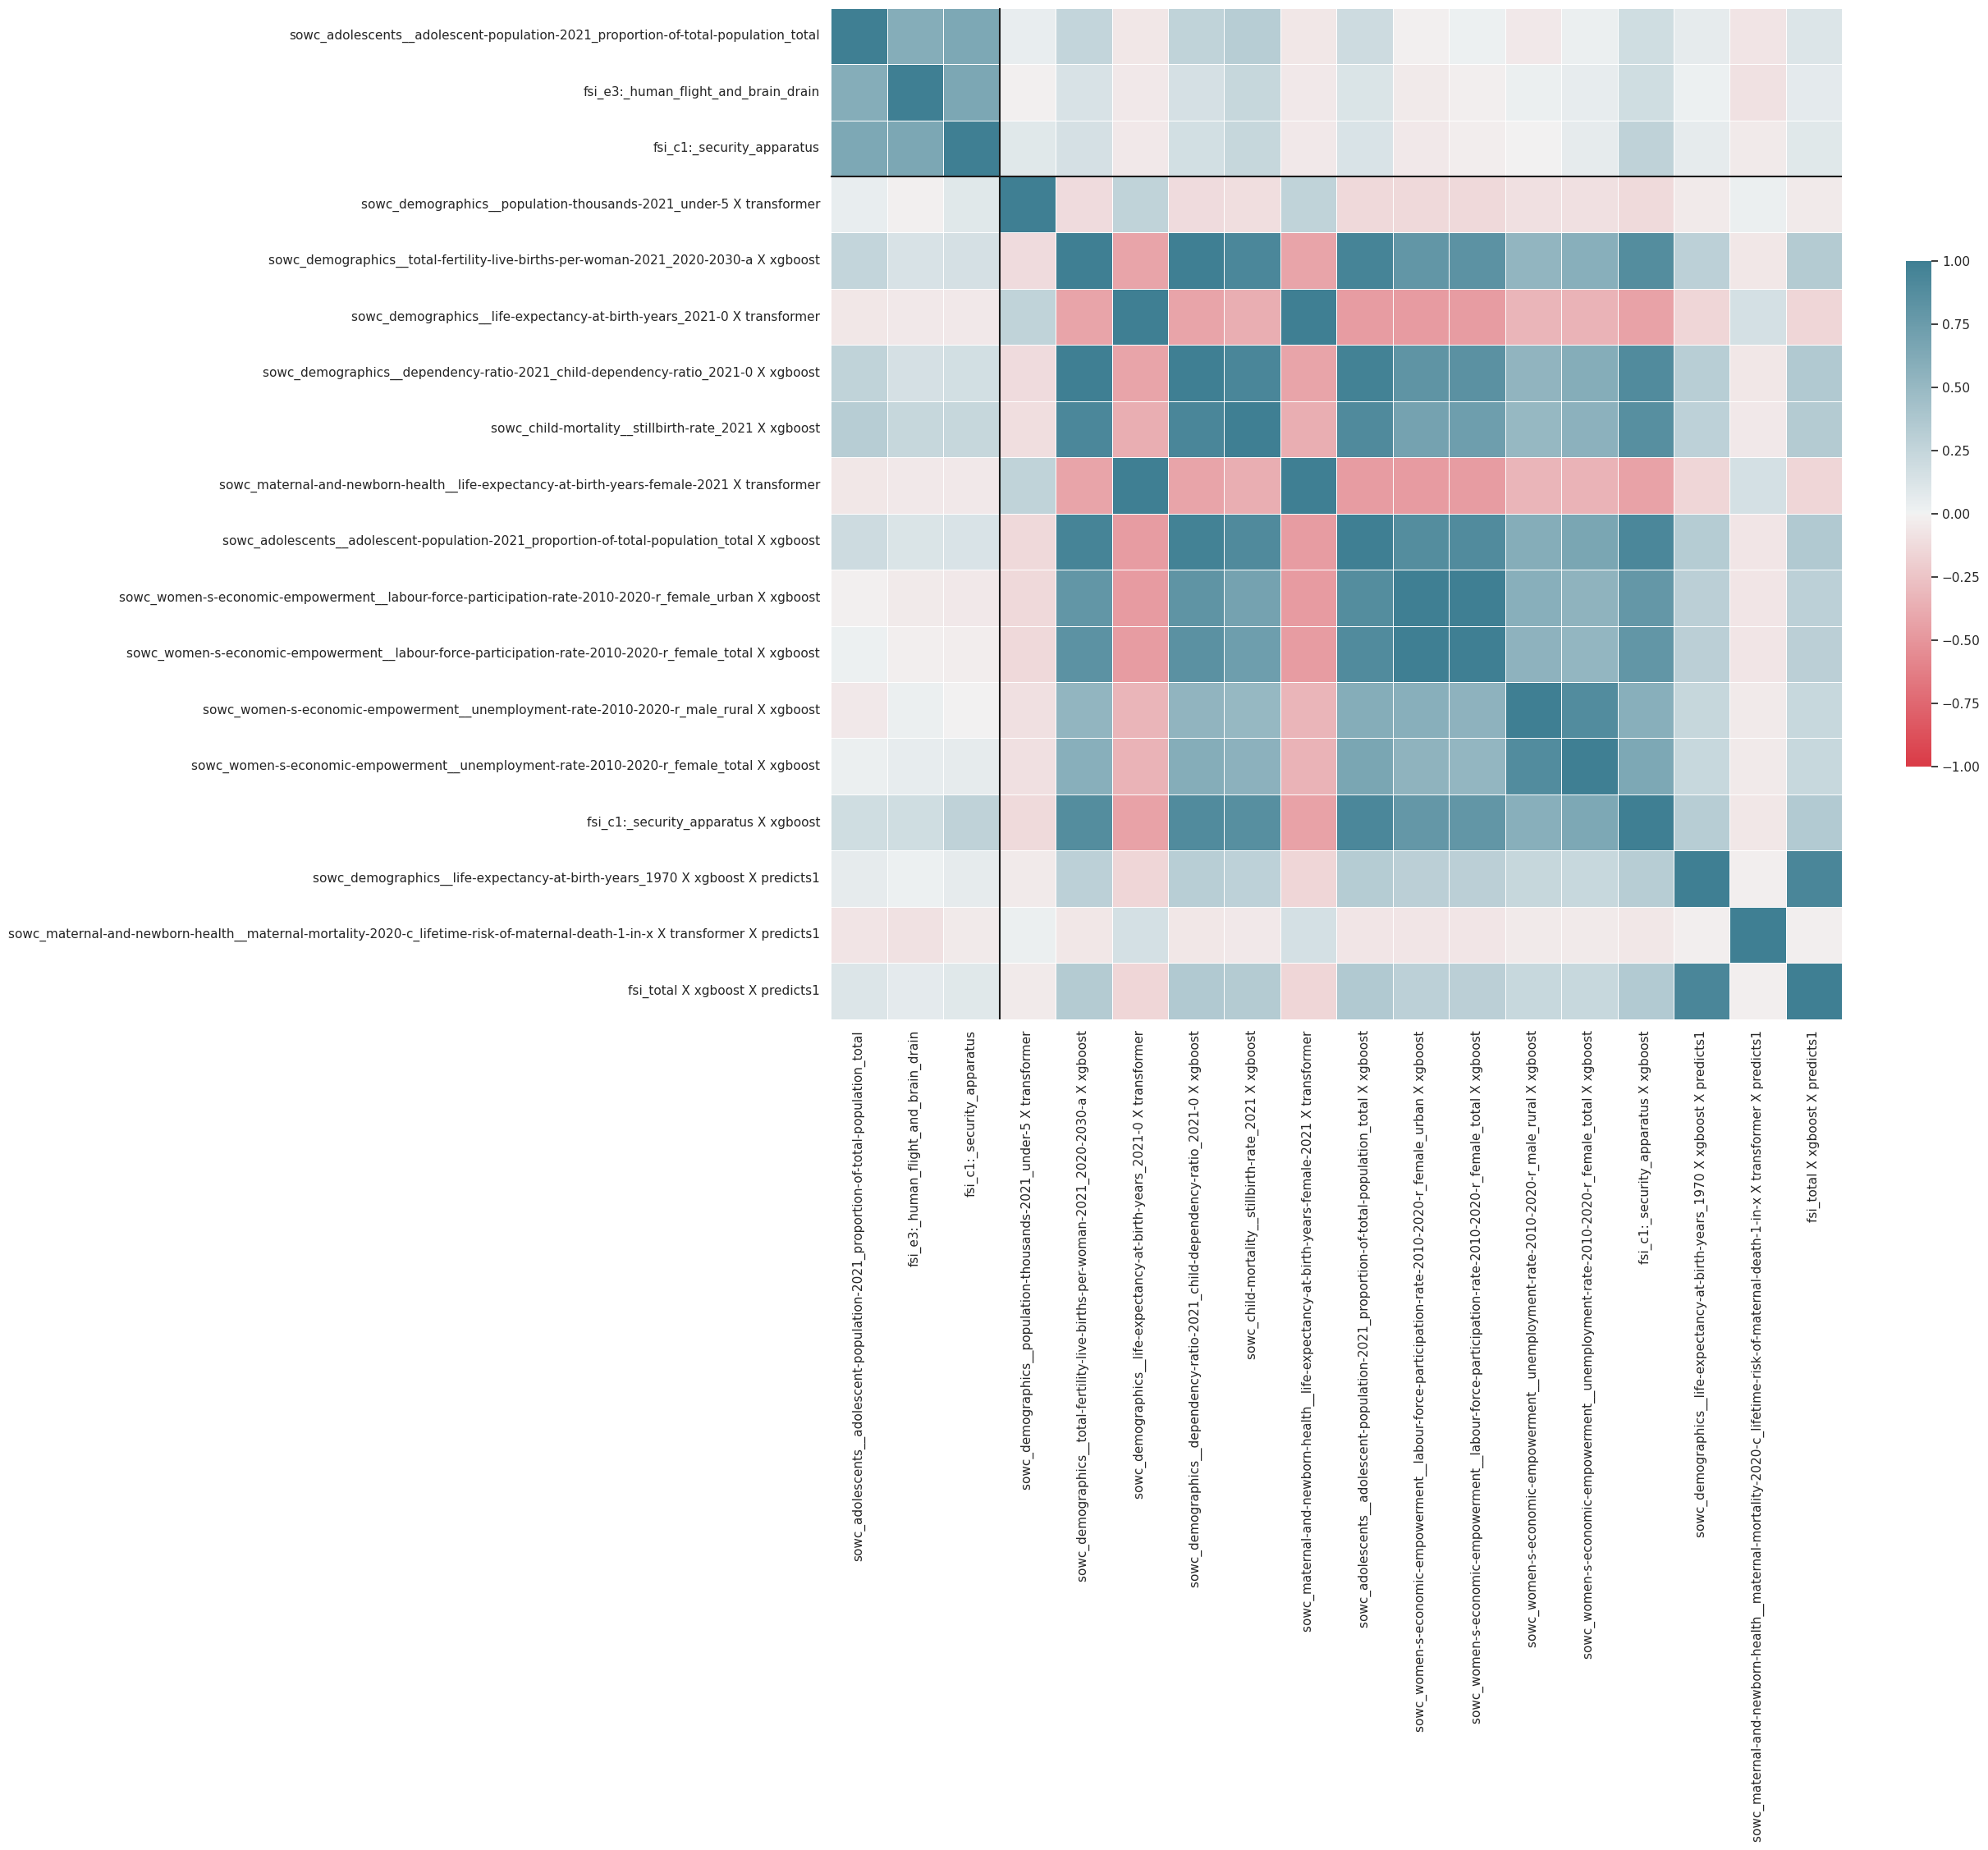

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# A good function from Evan Wheeler I've edited just a little bit
def corr_heatmap(df):
    # plot correlation heatmap based on code from:
    # https://medium.com/@nikolh92/helpful-visualisations-for-linear-regression-646a5648ad9d
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    #mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20, 16))
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True,
                       linewidths=.5, annot=False, cbar_kws={"shrink": .5})

corr_heatmap(scaled_df_1)
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif_data(df):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return print(vif_data)

get_vif_data(scaled_df_1)

                                             Variable          VIF
0   sowc_adolescents__adolescent-population-2021_p...     2.840061
1                fsi_e3:_human_flight_and_brain_drain     2.109434
2                          fsi_c1:_security_apparatus     3.142365
3   sowc_demographics__population-thousands-2021_u...     1.124507
4   sowc_demographics__total-fertility-live-births...   120.655578
5   sowc_demographics__life-expectancy-at-birth-ye...  4282.256592
6   sowc_demographics__dependency-ratio-2021_child...   247.678072
7   sowc_child-mortality__stillbirth-rate_2021 X x...    10.659933
8   sowc_maternal-and-newborn-health__life-expecta...  4275.444819
9   sowc_adolescents__adolescent-population-2021_p...    87.597719
10  sowc_women-s-economic-empowerment__labour-forc...   127.512754
11  sowc_women-s-economic-empowerment__labour-forc...   121.469182
12  sowc_women-s-economic-empowerment__unemploymen...     6.632494
13  sowc_women-s-economic-empowerment__unemploymen...     7.76

In [17]:
design_matrix_2 = scaled_df_1.copy()
design_matrix_2.drop(columns=['sowc_demographics__life-expectancy-at-birth-years_2021-0 X transformer',
                              'sowc_maternal-and-newborn-health__life-expectancy-at-birth-years-female-2021 X transformer',
                             'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_total X xgboost'], inplace=True)
                                
#     'sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost',

In [18]:
model_2 = sm.OLS(y, sm.add_constant(design_matrix_2))
model2_fit = model_2.fit()
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     50.82
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          7.59e-114
Time:                        02:05:23   Log-Likelihood:                 626.16
No. Observations:                1092   AIC:                            -1220.
Df Residuals:                    1076   BIC:                            -1140.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================================
                                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                            0.4345      0.004    104.508      0.000       0.426       0.443
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total                                                0.0492      0.007      7.282      0.000       0.036       0.062
fsi_e3:_human_flight_and_brain_drain                                                                                            -0.0226      0.006     -3.812      0.000      -0.034      -0.011
fsi_c1:_security_apparatus                                                                                                       0.0508      0.007      6.987      0.000       0.037       0.065
sowc_demographics__population-thousands-2021_under-5 X transformer                                                               0.0194      0.004      4.570      0.000       0.011       0.028
sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost                                             -0.2866      0.045     -6.329      0.000      -0.375      -0.198
sowc_demographics__dependency-ratio-2021_child-dependency-ratio_2021-0 X xgboost                                                 0.3607      0.064      5.632      0.000       0.235       0.486
sowc_child-mortality__stillbirth-rate_2021 X xgboost                                                                             0.0552      0.013      4.162      0.000       0.029       0.081
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total X xgboost                                     -0.2085      0.038     -5.480      0.000      -0.283      -0.134
sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_urban X xgboost                            0.0423      0.013      3.326      0.001       0.017       0.067
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_male_rural X xgboost                                           -0.0560      0.011     -5.322      0.000      -0.077      -0.035
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_female_total X xgboost                                          0.0615      0.012      5.311      0.000       0.039       0.084
fsi_c1:_security_apparatus X xgboost                                                                                             0.0735      0.014      5.149      0.000       0.046       0

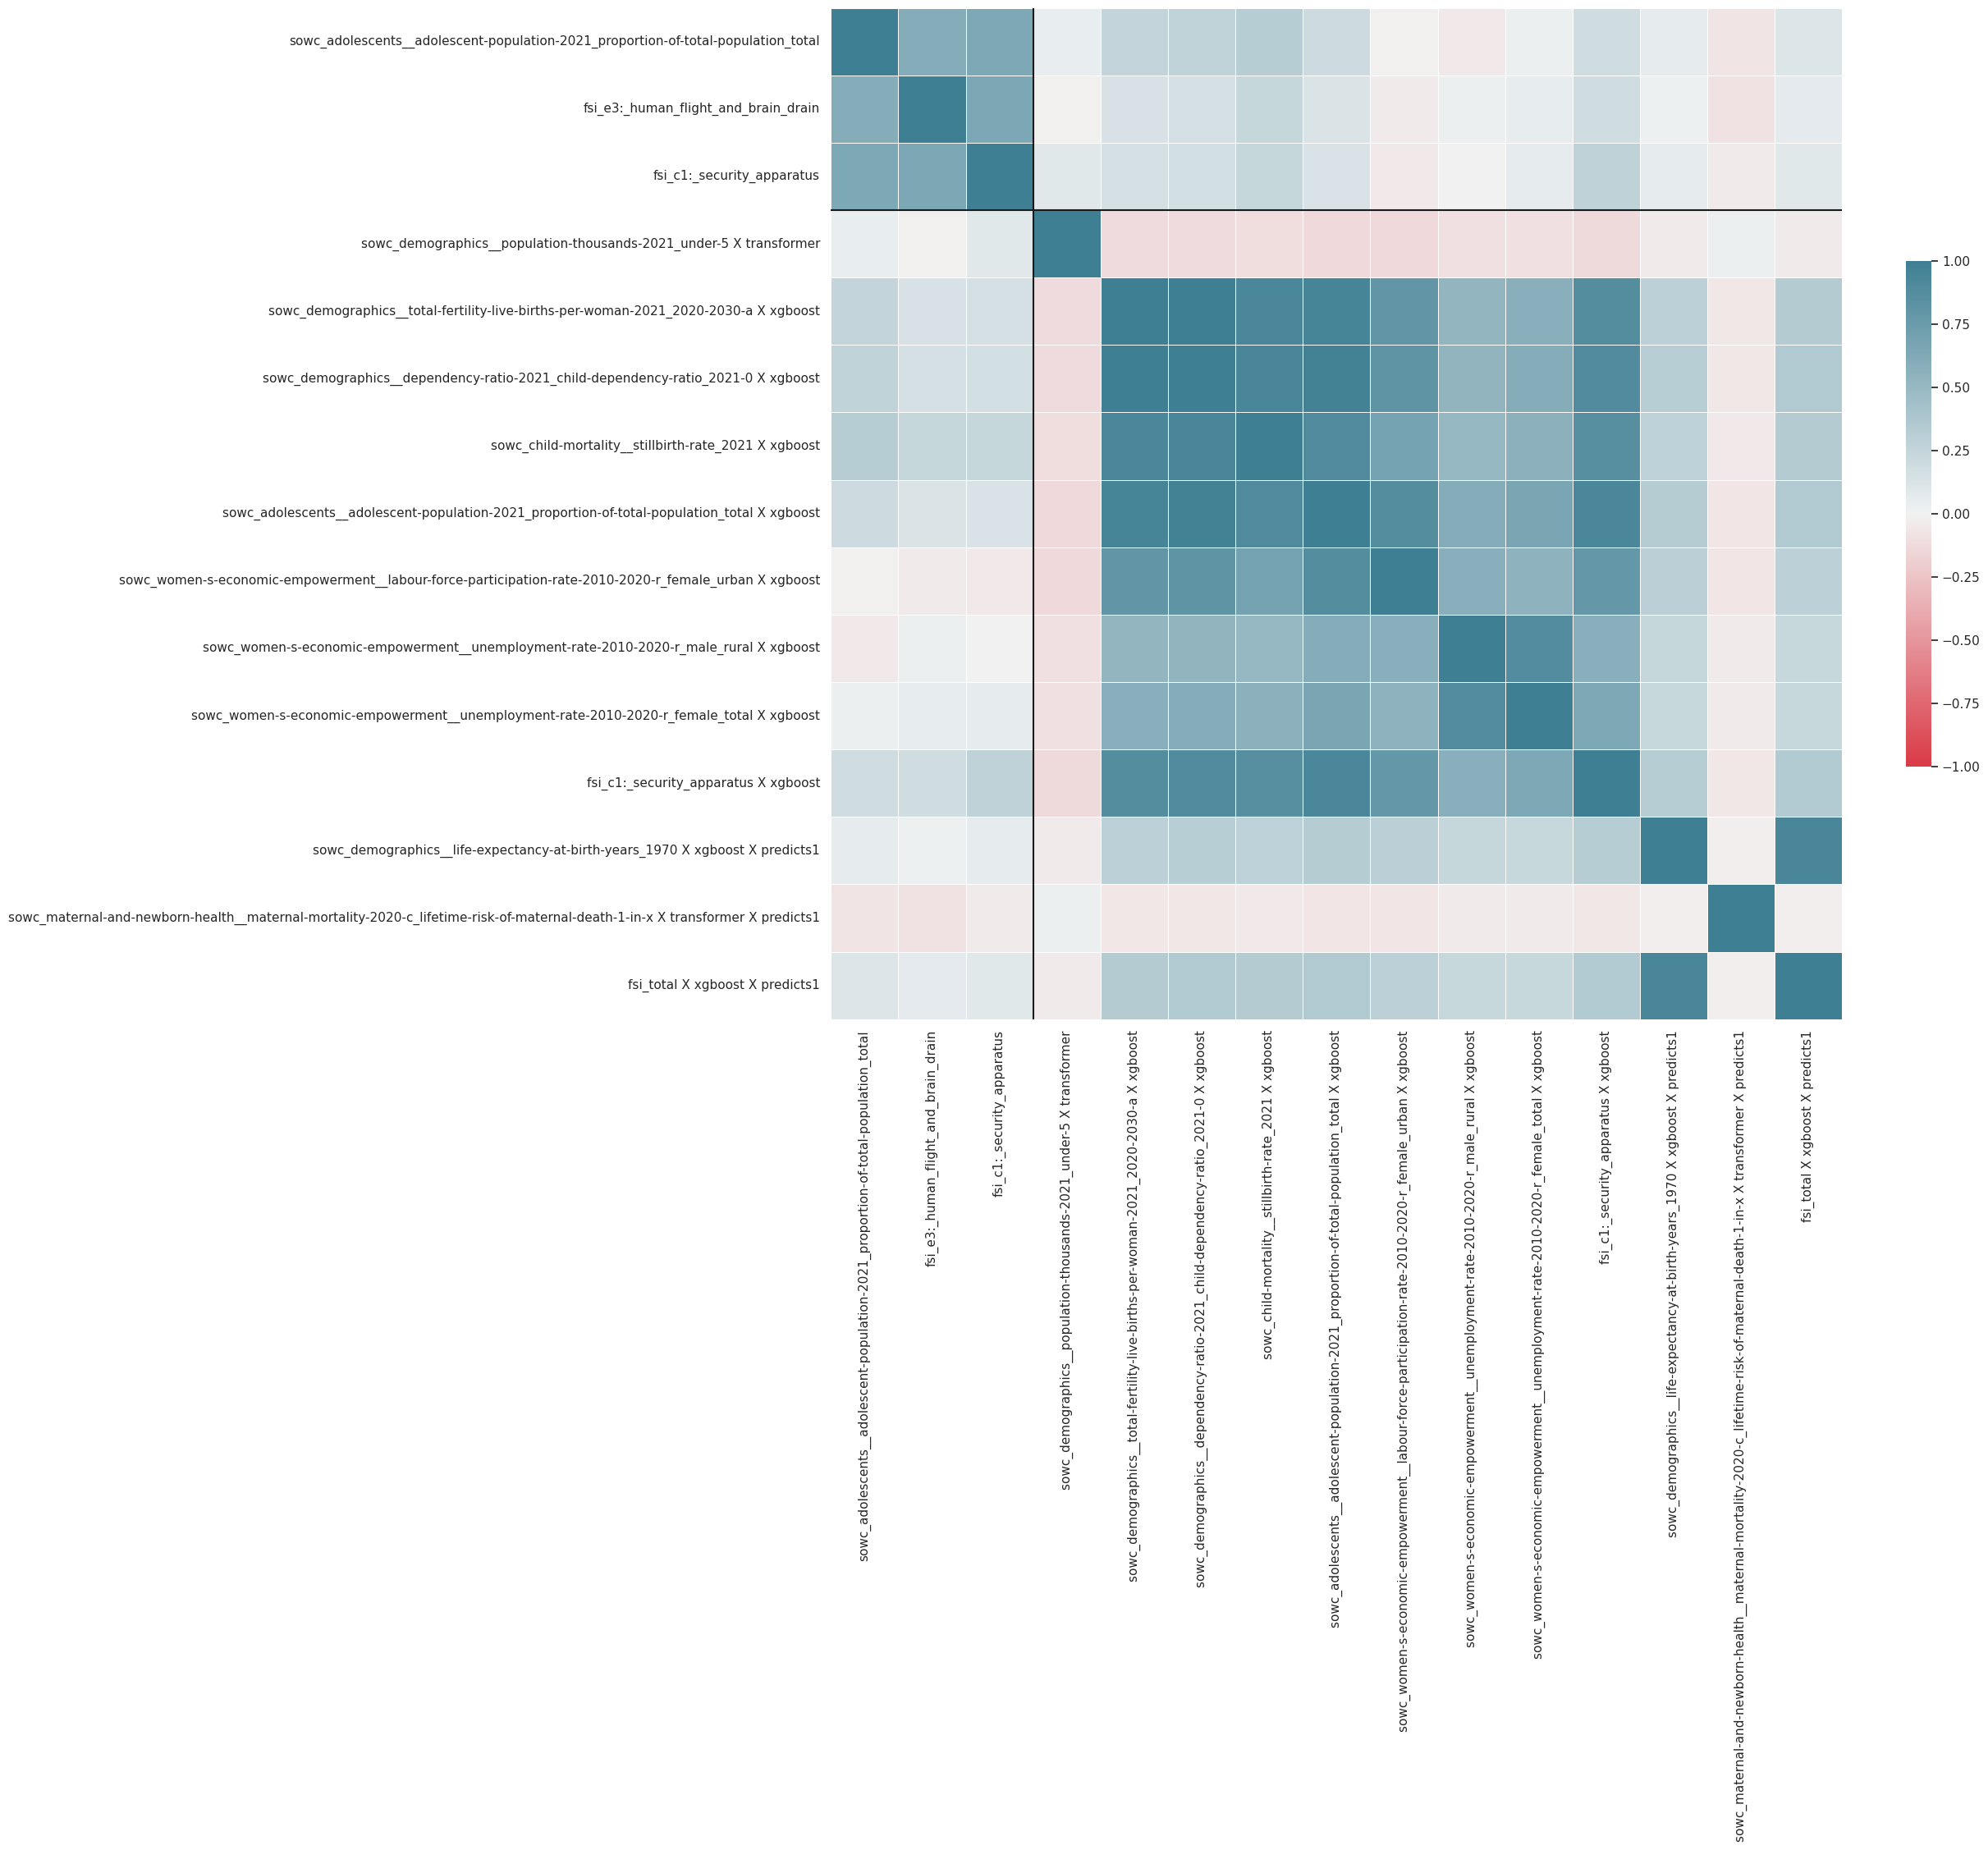

In [19]:
corr_heatmap(design_matrix_2)
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

In [20]:
get_vif_data(design_matrix_2)

                                             Variable         VIF
0   sowc_adolescents__adolescent-population-2021_p...    2.640942
1                fsi_e3:_human_flight_and_brain_drain    2.028992
2                          fsi_c1:_security_apparatus    3.055550
3   sowc_demographics__population-thousands-2021_u...    1.044936
4   sowc_demographics__total-fertility-live-births...  118.631277
5   sowc_demographics__dependency-ratio-2021_child...  237.240560
6   sowc_child-mortality__stillbirth-rate_2021 X x...   10.187870
7   sowc_adolescents__adolescent-population-2021_p...   83.739641
8   sowc_women-s-economic-empowerment__labour-forc...    9.366053
9   sowc_women-s-economic-empowerment__unemploymen...    6.402406
10  sowc_women-s-economic-empowerment__unemploymen...    7.764404
11               fsi_c1:_security_apparatus X xgboost   11.794686
12  sowc_demographics__life-expectancy-at-birth-ye...    8.566966
13  sowc_maternal-and-newborn-health__maternal-mor...    1.018119
14        

In [21]:
design_matrix_3 = design_matrix_2.copy()

design_matrix_3.drop(columns=['sowc_demographics__dependency-ratio-2021_child-dependency-ratio_2021-0 X xgboost',
                             'sowc_women-s-economic-empowerment__labour-force-participation-rate-2010-2020-r_female_urban X xgboost',
                             'sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total X xgboost'], inplace=True)

In [22]:
model_3 = sm.OLS(y, sm.add_constant(design_matrix_3))
model_3.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  error   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     58.59
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          1.04e-108
Time:                        02:05:24   Log-Likelihood:                 607.69
No. Observations:                1092   AIC:                            -1189.
Df Residuals:                    1079   BIC:                            -1124.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================================================
                                                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                            0.4345      0.004    102.898      0.000       0.426       0.443
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total                                                0.0508      0.007      7.758      0.000       0.038       0.064
fsi_e3:_human_flight_and_brain_drain                                                                                            -0.0231      0.006     -3.846      0.000      -0.035      -0.011
fsi_c1:_security_apparatus                                                                                                       0.0546      0.007      7.861      0.000       0.041       0.068
sowc_demographics__population-thousands-2021_under-5 X transformer                                                               0.0194      0.004      4.496      0.000       0.011       0.028
sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost                                             -0.0668      0.013     -5.087      0.000      -0.093      -0.041
sowc_child-mortality__stillbirth-rate_2021 X xgboost                                                                             0.0579      0.012      4.728      0.000       0.034       0.082
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_male_rural X xgboost                                           -0.0439      0.009     -4.635      0.000      -0.062      -0.025
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_female_total X xgboost                                          0.0383      0.010      3.862      0.000       0.019       0.058
fsi_c1:_security_apparatus X xgboost                                                                                             0.0465      0.011      4.136      0.000       0.024       0.069
sowc_demographics__life-expectancy-at-birth-years_1970 X xgboost X predicts1                                                     0.0781      0.012      6.371      0.000       0.054       0.102
sowc_maternal-and-newborn-health__maternal-mortality-2020-c_lifetime-risk-of-maternal-death-1-in-x X transformer X predicts1     0.0232      0.004      5.461      0.000       0.015       0.032
fsi_total X xgboost X predicts1                                                                                                 -0.1056      0.012     -8.529      0.000      -0.130      -0

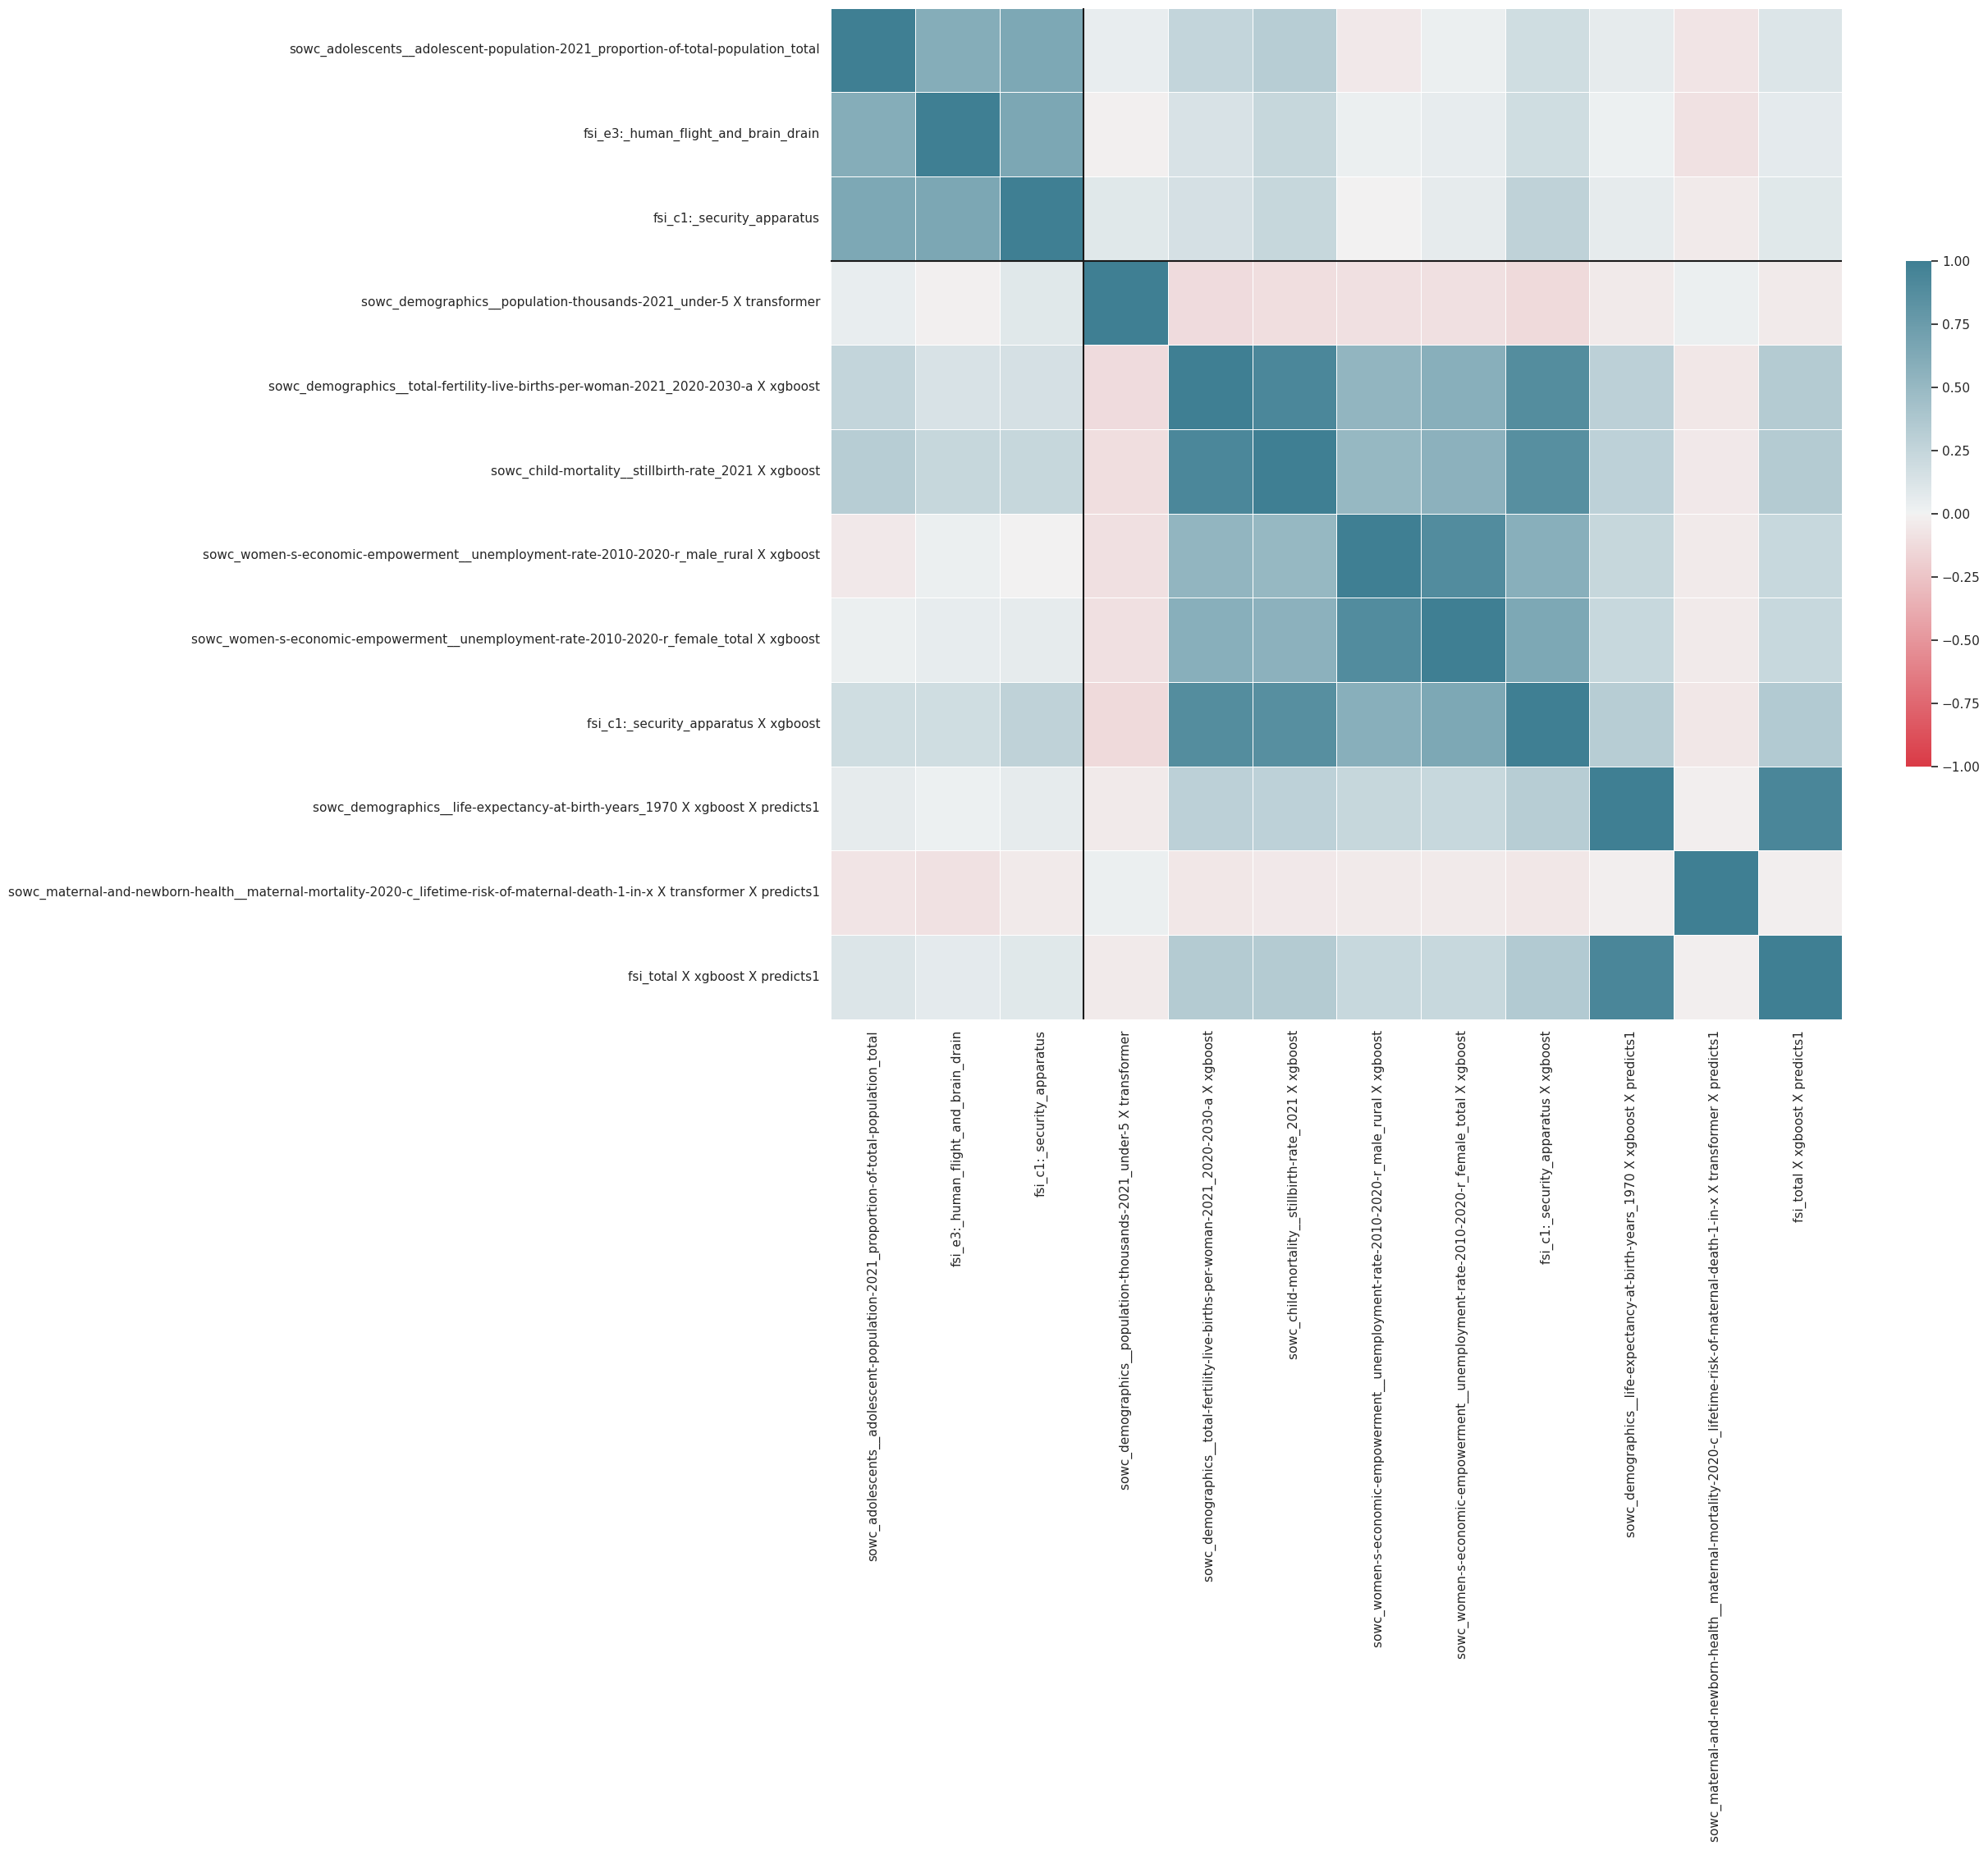

In [23]:
corr_heatmap(design_matrix_3)
_ = plt.axhline(y=3, c='k'); plt.axvline(x=3, c='k')

# Verifying Validity of Model

Now that we have a potential model, we have to verify that it's results are extrapolatable for the future.

- Normality: the assumption that the error between the real outcomes and predictions is normally distributed
- Homoskedasticity: the assumption that the error is consistent throughout our data.

Now that we have a potential model, we have to verify that it's results are interpretable in the future. Linear regression in statistics makes some assumptions in order for it to mathematically make sense. Normality: the assumption that the error between the real outcomes and predictions is normally distributed. And looking at the graph we can see that our errors definitly resemble a normal distribution.

The second assumption is that the error discrepancy stay consistent throughout the data. If we look at the graph theres maybe marginally more data clumped on the left but this should be an accceptable outcome.

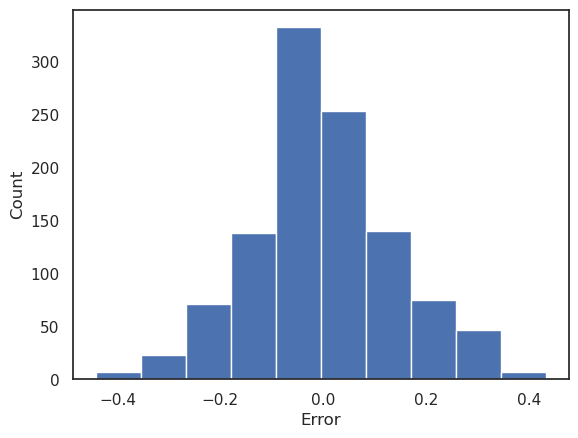

In [44]:
# Let's check our model assumption
## Normality
plt.hist(y-model_3.fit().predict())
plt.xlabel('Error')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.show()

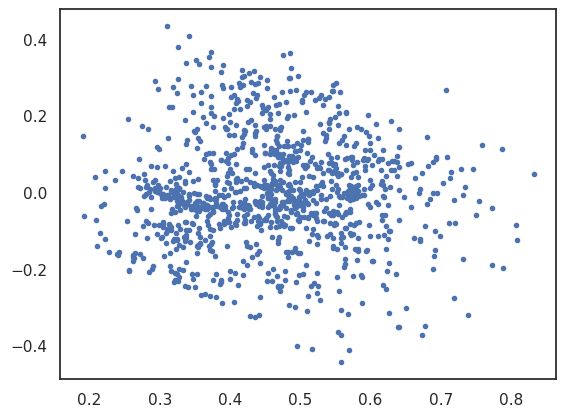

In [43]:
## Homoskedastic
plt.plot(model_3.fit().predict()+0.05*np.random.uniform(size=len(y)), y-model_3.fit().predict(), '.')

# Applying the model in test scenarios
- Split the data into 80% and 20%
- Train the model on 80% of the data and then compare predictions to the remaining 20% using the known outcomes as an "answer sheet".

We can now apply the model to a simulated real world scenario where we take 80% of our available data and use it to train the model. The other 20% of the data the model has never seen, so we can use those data points to compare the predicted error rate and the true error rate of the predictor models.

As you can see the error in the training data is slightly less, this is expected as the model will obviously preform better on data it has seen before. But the testing data error is not that much worse, maybe 1% in error, so proportionally 6% worse. What is interesting is that our first, "worst model", model 1 seems to preform slightly better than model_3.

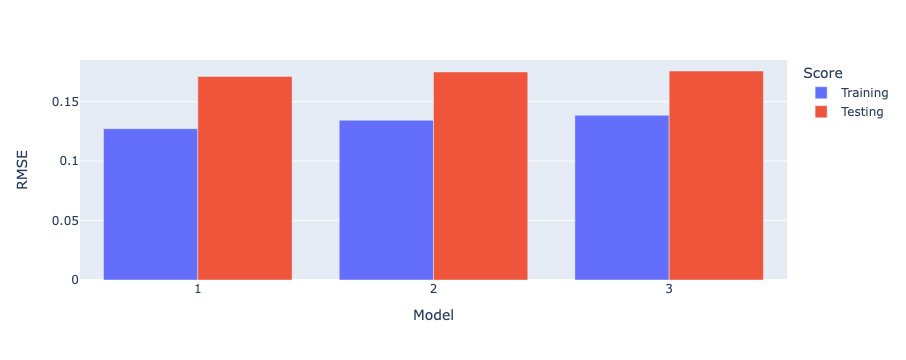

In [46]:
# Train-Test Validation
# np.random.seed(130)
train_size = 800
data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
train_indices = data_indices[train_size:]
test_indices = data_indices[:train_size]

model_1_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(scaled_df_1.iloc[train_indices])).fit()
model_1_train_RMSE = ((y[train_indices] - model_1_train_test_fit.predict())**2).mean()**.5
model_1_test_RMSE = ((y[test_indices] - 
                      model_1_train_test_fit.predict(sm.add_constant(scaled_df_1.iloc[test_indices]))
                     )**2).mean()**.5 

model_2_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix_2.iloc[train_indices])).fit()
model_2_train_RMSE = ((y[train_indices] - model_2_train_test_fit.predict())**2).mean()**.5
model_2_test_RMSE = ((y[test_indices] - 
                      model_2_train_test_fit.predict(sm.add_constant(design_matrix_2.iloc[test_indices]))
                     )**2).mean()**.5
# Best model
model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix_3.iloc[train_indices])).fit()
model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
model_3_test_RMSE = ((y[test_indices] - 
                      model_3_train_test_fit.predict(sm.add_constant(design_matrix_3.iloc[test_indices]))
                     )**2).mean()**.5

import plotly.express as px
px.bar(pd.DataFrame({'RMSE': [model_1_train_RMSE, model_2_train_RMSE, model_3_train_RMSE] + 
                             [model_1_test_RMSE, model_2_test_RMSE, model_3_test_RMSE],
                     'Score': ['Training']*3+['Testing']*3,
                     'Model': [1,2,3]+[1,2,3]}), 
       y='RMSE', x='Model', color='Score', barmode='group')

In [30]:
train_size = 800
reps = 1000
model_test_RMSEs_compare = np.array([0.0]*reps)

for i in range(reps):
    data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
    train_indices = data_indices[train_size:]
    test_indices = data_indices[:train_size]

    model_1_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(scaled_df_1.iloc[train_indices])).fit()
    model_1_train_RMSE = ((y[train_indices] - model_1_train_test_fit.predict())**2).mean()**.5
    model_1_test_RMSE = ((y[test_indices] - model_1_train_test_fit.predict(sm.add_constant(scaled_df_1.iloc[test_indices])))**2).mean()**.5 
    # Best model
    model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix_3.iloc[train_indices])).fit()
    model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
    model_3_test_RMSE = ((y[test_indices] - model_3_train_test_fit.predict(sm.add_constant(design_matrix_3.iloc[test_indices])))**2).mean()**.5
    
    model_test_RMSEs_compare[i] = model_3_test_RMSE - model_1_test_RMSE

import plotly.express as px
dis = px.histogram(pd.DataFrame({'diffrence between model3_test_RMSE to model1_test_RMSE': model_test_RMSEs_compare}),
                    x='diffrence between model3_test_RMSE to model1_test_RMSE')
dis.add_vline(x=np.quantile(model_test_RMSEs_compare, [0.05, 0.95])[0])
dis.add_vline(x=np.quantile(model_test_RMSEs_compare, [0.05, 0.95])[1])
np.quantile(model_test_RMSEs_compare, [0.05, 0.95])

array([-0.00415345,  0.0056359 ])

# Differences in initial vs final model
- model 1 has marginally higher accuracy but not a lot of explainability as to which predictor is responsible for the results
- model 3 essentially identical preformance, but significantly less predictors that are not co-linear


If we compare the root mean square error, which is just a fancy way to calculate the average error, we can see the difference in prediction errors between our two models. Running both models a thousand times we can see that the error difference is usually less than 1%, with the mode being around 0.3%. What this means is that our 3rd model, which had a much smaller condition number is able to achieve practically the same results but has half the predictor variables. Meaning that when this model is applied to future datasets it has never seen before it is much more likely to produce a more consistent and higher accuracy result. What we would like to avoid is overfitting when a model follows the training data too closely and can not generalize its results when dealing with new data. 

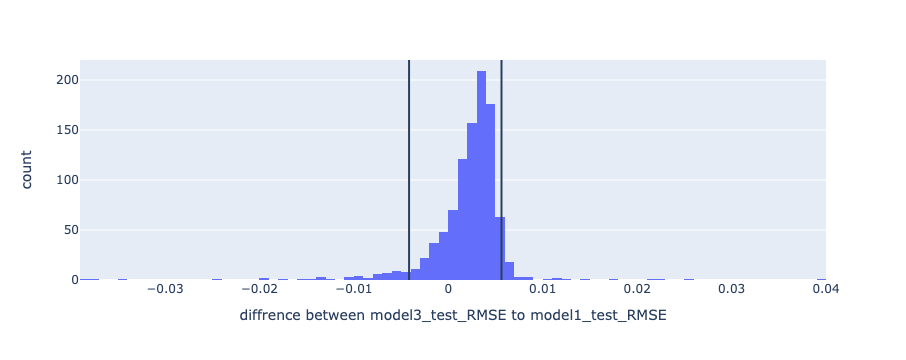

In [33]:
dis.show()

# So what?

- Trying to minimize our prediction error
- Positive coefficient increases errror
- Negative coefficient decreases error
- *predictor* X *model* is the interaction of some statistic with some model

How do we take the results of this model and apply it back to our problem of deciding which predictor model to use when predicting whether or not a conflict will take place? Well we are trying to minimize the error that we get between our model's predictions and the real world outcome. In the linear regression analysis each column has a coefficient, a negative coefficient means that a country with those properties using that model will have a lower error, and a positive coefficient means that a country with those properties using that model will have a larger error. If we look at the second part of the column, after the large "X" we can see that most of the interactions are with the xgboost model. So it seems like we choose if the country has x, x and x then use the xgboost prediction, otherwise use some average of the transformer and ffnn model predictions. 

However, there is even more nuance to the results. As I previously mentioned the coefficients can be positive or negative, so seeing the columns in our analysis we can see that if a country has high fertility, high rural male unemployment rate and its fsi score is high then using xgboost decreases the average error. However, there are some predictors like child mortality rate and life expectancy at birth that increases the error of xgboost. 

As such there is no simple answer as to what model should be used for what country, but by feeding the countries statistics into our linear regression model, we can estimate which prediction will most likely be correct. 

In [29]:
model_3_train_test_fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.4366,0.008,53.912,0.000,0.421,0.453
sowc_adolescents__adolescent-population-2021_proportion-of-total-population_total,0.0348,0.012,2.836,0.005,0.011,0.059
fsi_e3:_human_flight_and_brain_drain,-0.0101,0.011,-0.894,0.372,-0.032,0.012
fsi_c1:_security_apparatus,0.0512,0.013,3.906,0.000,0.025,0.077
sowc_demographics__population-thousands-2021_under-5 X transformer,0.0270,0.007,3.652,0.000,0.012,0.042
sowc_demographics__total-fertility-live-births-per-woman-2021_2020-2030-a X xgboost,-0.0681,0.027,-2.527,0.012,-0.121,-0.015
sowc_child-mortality__stillbirth-rate_2021 X xgboost,0.0782,0.025,3.172,0.002,0.030,0.127
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_male_rural X xgboost,-0.0805,0.019,-4.315,0.000,-0.117,-0.044
sowc_women-s-economic-empowerment__unemployment-rate-2010-2020-r_female_total X xgboost,0.0503,0.018,2.797,0.006,0.015,0.086
fsi_c1:_security_apparatus X xgboost,0.0517,0.023,2.246,0.025,0.006,0.097


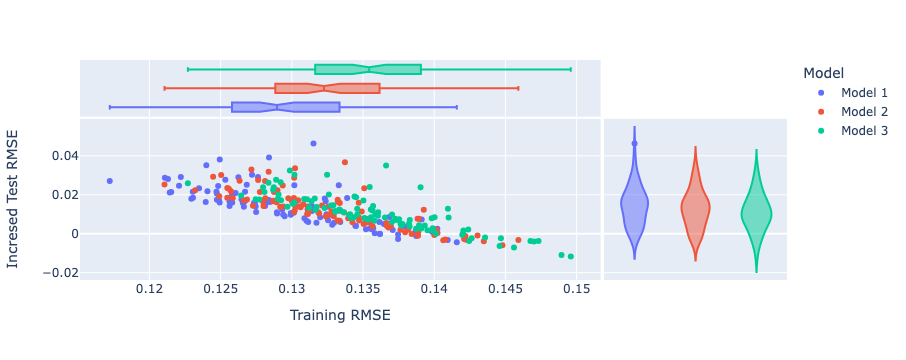

In [37]:
# Visulization of the train & test RMSEs

reps = 100
model_1_train_RMSEs = np.array([0.0]*reps)
model_2_train_RMSEs = np.array([0.0]*reps)
model_3_train_RMSEs = np.array([0.0]*reps)

model_1_test_RMSEs = np.array([0.0]*reps)
model_2_test_RMSEs = np.array([0.0]*reps)
model_3_test_RMSEs = np.array([0.0]*reps)

for i in range(reps):
    data_indices = np.random.choice(design_matrix.index, size=design_matrix.shape[0], replace=False)
    train_indices = data_indices[train_size:]
    test_indices = data_indices[:train_size]
    
    model_1_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(scaled_df_1.iloc[train_indices])).fit()
    model_1_train_RMSE = ((y[train_indices] - model_1_train_test_fit.predict())**2).mean()**.5
    model_1_test_RMSE = ((y[test_indices] - 
                          model_1_train_test_fit.predict(sm.add_constant(scaled_df_1.iloc[test_indices]))
                         )**2).mean()**.5
    model_1_train_RMSEs[i] = model_1_train_RMSE
    model_1_test_RMSEs[i] = model_1_test_RMSE

    model_2_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix_2.iloc[train_indices])).fit()
    model_2_train_RMSE = ((y[train_indices] - model_2_train_test_fit.predict())**2).mean()**.5
    model_2_test_RMSE = ((y[test_indices] - 
                          model_2_train_test_fit.predict(sm.add_constant(design_matrix_2.iloc[test_indices]))
                         )**2).mean()**.5
    model_2_train_RMSEs[i] = model_2_train_RMSE
    model_2_test_RMSEs[i] = model_2_test_RMSE
    
    # Best model
    model_3_train_test_fit = sm.OLS(y[train_indices], sm.add_constant(design_matrix_3.iloc[train_indices])).fit()
    model_3_train_RMSE = ((y[train_indices] - model_3_train_test_fit.predict())**2).mean()**.5
    model_3_test_RMSE = ((y[test_indices] - 
                          model_3_train_test_fit.predict(sm.add_constant(design_matrix_3.iloc[test_indices]))
                         )**2).mean()**.5
    model_3_train_RMSEs[i] = model_3_train_RMSE
    model_3_test_RMSEs[i] = model_3_test_RMSE

px.scatter(pd.DataFrame({'Incresed Test RMSE': (model_1_test_RMSEs-model_1_train_RMSEs).tolist()
                         +(model_2_test_RMSEs-model_2_train_RMSEs).tolist()+
                         (model_3_test_RMSEs-model_3_train_RMSEs).tolist(),
                         'Training RMSE': model_1_train_RMSEs.tolist()+model_2_train_RMSEs.tolist()+model_3_train_RMSEs.tolist(),
                         'Model': ["Model 1"]*reps+["Model 2"]*reps+["Model 3"]*reps}),
           x='Training RMSE', y='Incresed Test RMSE', color='Model',
           marginal_x="box", marginal_y="violin")

# But what if a prediction is wrong...
- Incorrectly predicting a war would create unnecessary tension between countries
- Predictions can be self fulfilling prophesies
- Incorrectly predicting the absence of war could cost thousands of lives
- Who should be allowed to use this model? Canada? USA? China?
- This model is not flawless, it must be used as an additional tool in a toolbox full of other methods.

This project is more than just a question in the textbook. The effects and consequences of accurately and especially inaccurately predicting an escalation are very real and have long term consequences. 

For example, incorrectly predicting that a war is going to happen might create unnecessary tension between two countries and potentially economic losses. Then UNICEF might have to send resources or enact safety measures unnecessarily. Not only could economic harm be done, but the increased tension could create a self fulfilling prophesy where a conflict breaks out. When all parties believe that a conflict is inevitable because of some math equations, the conflict becomes truly inevitable.

Another possibility is incorrectly predicting that a war will not happen. This would lead to a reduction in preparation done by UNICEF which could lead to a greater loss in life had no prediction been made.

The problems don’t stop at just the accuracy of the model or self fulfilling prophesies. Say we are able to make a model with 99% accuracy. Should we make this model available to some governments and not to others ? To some political parties and not to others ? To some agencies or bureaus and not to others ? 

While for now this technology is still in its infancy it is not unrealistic to suppose that with advancements in technology we will be able to predict more than just which country will be at conflict next month. Isaac Asimov has a very interesting series on this called “Foundation”, in which he invents a science that can with certainty predict major events in society, such as wars, far out into the future.

So it is important to keep in mind that these predictions are not an end all and be all to our worlds problems but just another tool in our toolbox. While there are many many many ethical considerations to be taken into account, a model built upon rigorous statistical concepts will be, if only marginally, better than shooting in the dark.